This notebook is a copy of 'Building and running neural networks on batlike call data', with the exception that the network is being trained to detect the sounds in a shorter time window, and has a bit more of input data samples.

In [1]:
# load the simulated data 
import pickle 
datafile = open('batlike_data_5ms.pkl')
all_data = pickle.load(datafile)

In [2]:
training_imgs, training_labels = all_data['training']
testing_imgs, testing_labels = all_data['testing']

In [3]:
training_imgs.shape

(10500, 33, 29)

In [4]:
# convert the label data into keras compatible format 
from keras.utils import np_utils
testing_labels = np_utils.to_categorical(testing_labels)
training_labels = np_utils.to_categorical(training_labels)

Using TensorFlow backend.


In [5]:
# reshape the image data into a 1d shape per image :
def reshape_imgs_for_network_input(tensor):
    num_imgs, nrows, ncols = tensor.shape
    reshaped_array = tensor.reshape(num_imgs, nrows*ncols)
    return(reshaped_array, nrows, ncols)

In [6]:
training_input_imgs, nrows, ncols = reshape_imgs_for_network_input(training_imgs)
testing_input_imgs, _, _ = reshape_imgs_for_network_input(testing_imgs)

In [7]:
training_input_imgs.shape

(10500, 957)

In [8]:
nrows*ncols, nrows, ncols

(957, 33, 29)

In [9]:
# building up the network to be usd : 
import keras 
from keras import models
from keras import layers

In [10]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(nrows*ncols,)))
network.add(layers.Dense(2, activation='softmax'))

In [11]:
# now we compile the network and state its properties 
network.compile(optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'])

In [12]:
network_history = network.fit(training_input_imgs, training_labels
            , epochs=5, batch_size=50, 
                              validation_data=(testing_input_imgs, testing_labels))

Train on 10500 samples, validate on 3500 samples
Epoch 1/5
10500/10500 [==============================] - 4s 377us/step - loss: 0.1704 - binary_accuracy: 0.9456 - val_loss: 0.0324 - val_binary_accuracy: 0.9969
Epoch 2/5
10500/10500 [==============================] - 3s 325us/step - loss: 0.0106 - binary_accuracy: 0.9989 - val_loss: 0.0145 - val_binary_accuracy: 0.9954
Epoch 3/5
10500/10500 [==============================] - 3s 325us/step - loss: 0.0020 - binary_accuracy: 0.9998 - val_loss: 0.0174 - val_binary_accuracy: 0.9937
Epoch 4/5
10500/10500 [==============================] - 4s 352us/step - loss: 4.9187e-04 - binary_accuracy: 0.9998 - val_loss: 0.0165 - val_binary_accuracy: 0.9951
Epoch 5/5
10500/10500 [==============================] - 3s 326us/step - loss: 1.3182e-04 - binary_accuracy: 1.0000 - val_loss: 0.0324 - val_binary_accuracy: 0.9914


#### save network model after fitting for future use
models.save_model(network, 'batlikecall_detector_v1_5ms.h5')

In [13]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8106799077608139212
]


In [14]:
history_dict = network_history.history
history_dict.keys()

['loss', 'val_binary_accuracy', 'val_loss', 'binary_accuracy']

The 5ms network has moved further than the 10ms network, and features a validation accuracy of 99% ! , this might also just be because there's about twice the amount of data ...

In [15]:
%matplotlib notebook

<IPython.core.display.Javascript object>


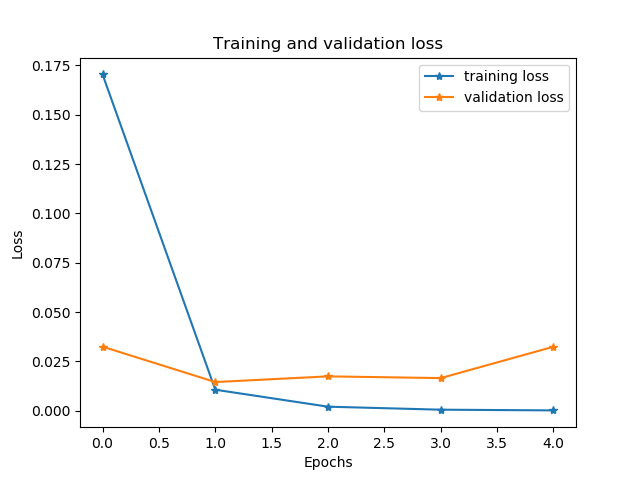

<IPython.core.display.Javascript object>


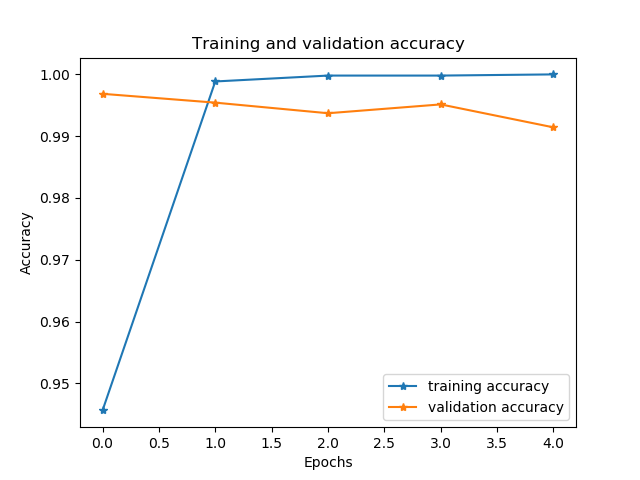

Text(0.5,0,'Epochs')

In [55]:
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000

plt.figure()
plt.plot(history_dict['loss'],'-*',label='training loss');
plt.plot(history_dict['val_loss'],'-*',label='validation loss');
plt.legend();plt.title('Training and validation loss');plt.ylabel('Loss');plt.xlabel('Epochs')


plt.figure()
plt.plot(history_dict['binary_accuracy'],'-*',label='training accuracy');
plt.plot(history_dict['val_binary_accuracy'],'-*',label='validation accuracy');
plt.legend();plt.title('Training and validation accuracy')
plt.ylabel('Accuracy');plt.xlabel('Epochs')


<IPython.core.display.Javascript object>


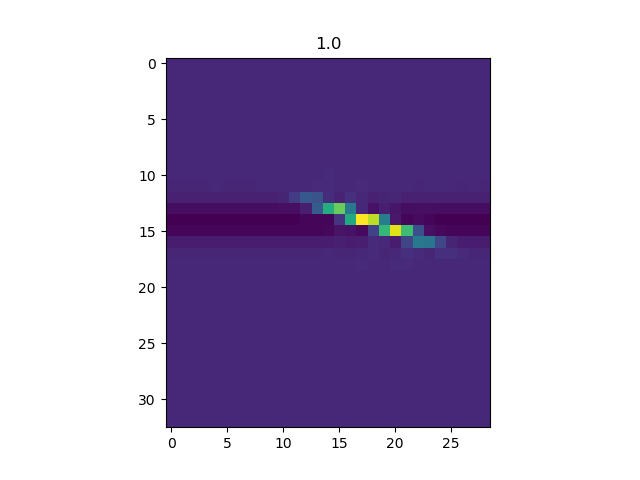

Text(0.5,1,'1.0')

In [17]:
plt.figure()
plt.imshow(testing_imgs[150,:,:])
plt.title(network.predict(testing_input_imgs[150:151,:])[0][1])


<IPython.core.display.Javascript object>


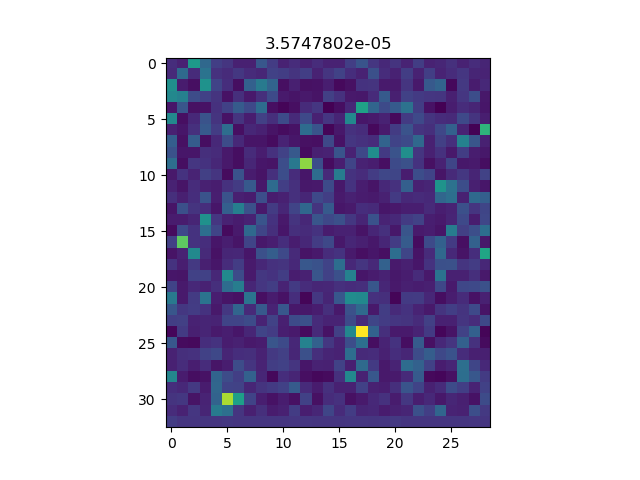

Text(0.5,1,'3.5747802e-05')

In [18]:
indx = 2000
plt.figure()
plt.imshow(testing_imgs[indx,:,:])
plt.title(network.predict(testing_input_imgs[indx:indx+1,:])[0][1])


### The effect of neural network structure :
I've seen with playing around with the MNISt dataset that the structure of the network can make a difference in how fast a network learns. Let's try and make a smaller/bigger network and see what comes out of it :

In [29]:
nrows, ncols

(33, 29)

In [38]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(nrows, ncols, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 31, 27, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [40]:
# add the classifiers now :
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [41]:
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [42]:
num_imgs, nrows, ncols = training_imgs.shape

In [43]:
# specially reshape the inputs for the Tensorflow backend:
train_imgs = training_imgs.reshape(num_imgs, nrows, ncols, 1)
test_imgs = testing_imgs.reshape(testing_imgs.shape[0], nrows, ncols, 1)

In [44]:
model_history = model.fit(train_imgs, training_labels, epochs=5,
          batch_size=100, validation_data=(test_imgs, testing_labels))

Train on 10500 samples, validate on 3500 samples
Epoch 1/5
10500/10500 [==============================] - 15s 1ms/step - loss: 0.1210 - acc: 0.9521 - val_loss: 0.0073 - val_acc: 0.9994
Epoch 2/5
10500/10500 [==============================] - 15s 1ms/step - loss: 0.0177 - acc: 0.9946 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3/5
10500/10500 [==============================] - 14s 1ms/step - loss: 0.0171 - acc: 0.9962 - val_loss: 5.4429e-04 - val_acc: 1.0000
Epoch 4/5
10500/10500 [==============================] - 14s 1ms/step - loss: 0.0027 - acc: 0.9990 - val_loss: 1.7467e-04 - val_acc: 1.0000
Epoch 5/5
10500/10500 [==============================] - 14s 1ms/step - loss: 0.0087 - acc: 0.9986 - val_loss: 7.9748e-05 - val_acc: 1.0000


In [45]:
m_history = model_history.history


<IPython.core.display.Javascript object>


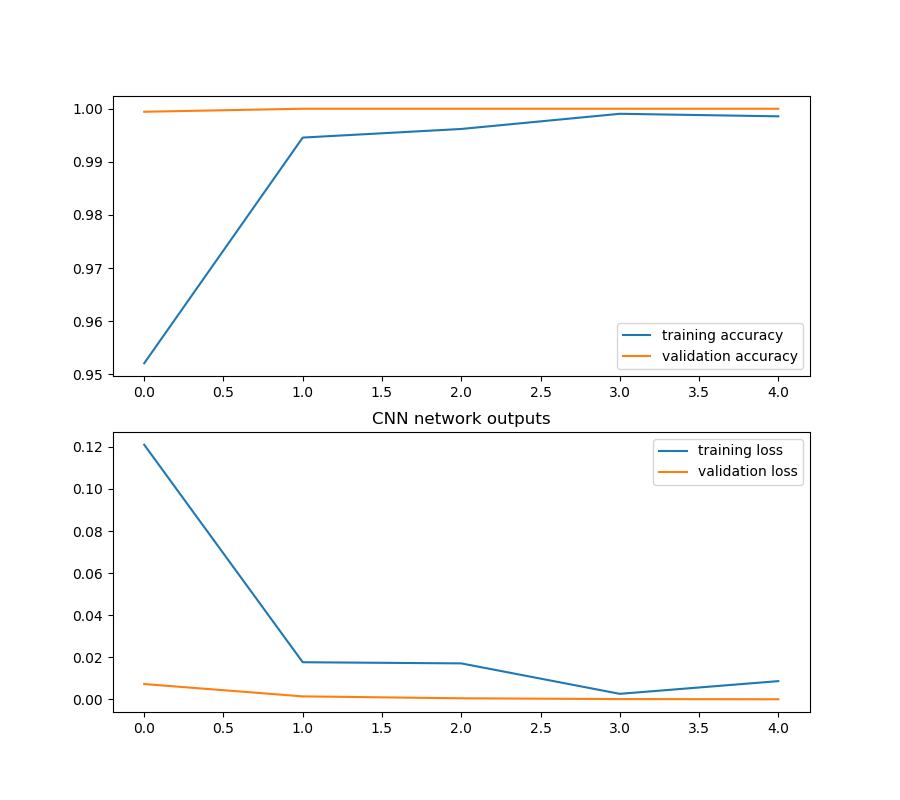

Text(0.5,1,'CNN network outputs')

In [53]:
plt.figure(figsize=(9,8))
plt.subplot(211)
plt.plot(m_history['acc'],label='training accuracy');plt.plot(m_history['val_acc'],label='validation accuracy')
plt.legend()
plt.subplot(212)
plt.plot(m_history['loss'], label='training loss');plt.plot(m_history['val_loss'], label='validation loss')
plt.legend()
plt.title('CNN network outputs')



models.save_model(model, 'batlikecall_detector_v2CNN_5ms.h5')